# Get Sample Colors
> Get sample colors by using [K-Means Clustering](https://en.wikipedia.org/wiki/K-means_clustering)

[Back to <b>contents</b>](../README.md)

First, represent the main colors of shoe in shoes.csv in 3D. <br>
Numpy, Matplotlib and csv libraries are needed

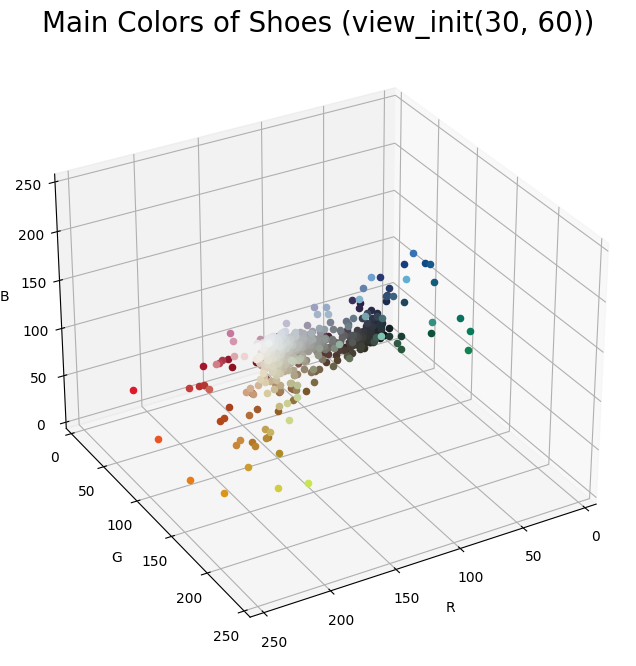

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import copy
import mycolor
%matplotlib inline

def load_shoe_data(filename):
  class ShoeData:
    data = []
    target = []
    feature_names = ['Name','Brand','Colors','Link','wish','review']
  shoes = ShoeData()
  with open(filename,'r', encoding ='utf-8') as f:
    for items in csv.reader(f):
      if items[0].startswith('#'): continue
      shoes.target.append(eval(items[2]))
      shoes.data.append(items)
    shoes.data = np.array(shoes.data)
    return shoes

# whow the plot in 3d from the data frame.
def show_data_3d(df):
  fig = plt.figure(figsize = (8, 8))
  ax2 = fig.add_subplot(111, projection='3d',xlabel ="R", ylabel ="G", zlabel ="B")
  ax2.set_title(f"Color Clustered (k = {k})", size = 20)
  for index, row in df.iterrows():
    ax2.scatter(row['R'], row['G'], row['B'], color = row['color']/255.0)
  plt.show()

# show 25 colors with form 5*5
def show_colors_2d(centers):
  arr_2d = copy.deepcopy(centers.tolist())
  mycolor.sort(arr_2d)
  arr_2d = np.reshape(arr_2d, (5,5,3))
  plt.imshow(arr_2d)


shoes = load_shoe_data('../data/shoes.csv')
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d', xlabel ="R", ylabel ="G", zlabel ="B")
ax.set_title("Main Colors of Shoes (view_init(30, 60))", size = 20)

for colors in shoes.target:
  RGBP = colors[0]
  RGB = np.array(RGBP[:-1])
  ax.scatter(RGB[0], RGB[1], RGB[2], color = RGB/255.0)
  
ax.view_init(30, 60)

Each view_init show plot by different angles.
<br>
<img src = "https://user-images.githubusercontent.com/67538999/206905943-43a136ea-1def-4b92-818b-f23a253b1e6d.png" width = 800vw>

### Data analysis
1. As expected, the main colors of shoe are mostly achromatic.
2. <span style ="background-color : Black; color : white;">Black</span> and <span style ="background-color : White; color : Black;">white</span> are usually abundant, and the rest of the colors are evenly distributed.
3. But we can't get suitable colors with this information.


## Goal
> I want to compress <b>color information</b> into <b>less number of colors</b>.
1. A small number of colors should <mark>effeciently</mark> represent the color of the shoes.
2. Similar colors should be removed. To do this, divide the colors into groups.

    **Use [KMeans](https://en.wikipedia.org/wiki/K-means_clustering) clustering**


In [12]:
from sklearn.cluster import KMeans #for K-Means

* Import the necessary modules. <br>
* Then, we convert the data we get into a <b>data frame</b> and convert it into a <b>float type</b>.


In [13]:
data = []
for colors in shoes.target:
  RGBP = colors[0]
  RGB = np.array(RGBP[:-1])
  data.append(RGB)
df = pd.DataFrame(columns=['R','G','B'], data=data)
df.head(10)

,R,G,B
0,218,222,224
1,203,204,206
2,52,51,50
3,199,204,206
4,223,226,227
5,172,174,182
6,162,126,87
7,52,51,50
8,131,89,52
9,209,212,216


In [14]:
df[['R','G','B']].std()

R    77.323959
G    76.521322
B    75.205438
dtype: float64

 > First, let's get the result by setting the number of K-means clusters to 3.

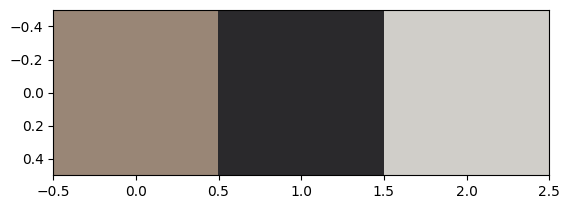

In [15]:
points = df.values
k = 3
kmeans = KMeans(n_clusters = k).fit(points)
centers = kmeans.cluster_centers_.round().astype(int)
plt.imshow([centers])


Modify the dataframe to map the centers to each color.

In [16]:
df['cluster'] = kmeans.labels_
colors = []
for row in df['cluster']:
  colors.append(centers[row].round())
df['color'] = colors
df.head(5)

,R,G,B,cluster,color
0,218,222,224,2,"[208, 206, 201]"
1,203,204,206,2,"[208, 206, 201]"
2,52,51,50,1,"[42, 41, 44]"
3,199,204,206,2,"[208, 206, 201]"
4,223,226,227,2,"[208, 206, 201]"


Based on this, draw a 3d plot.

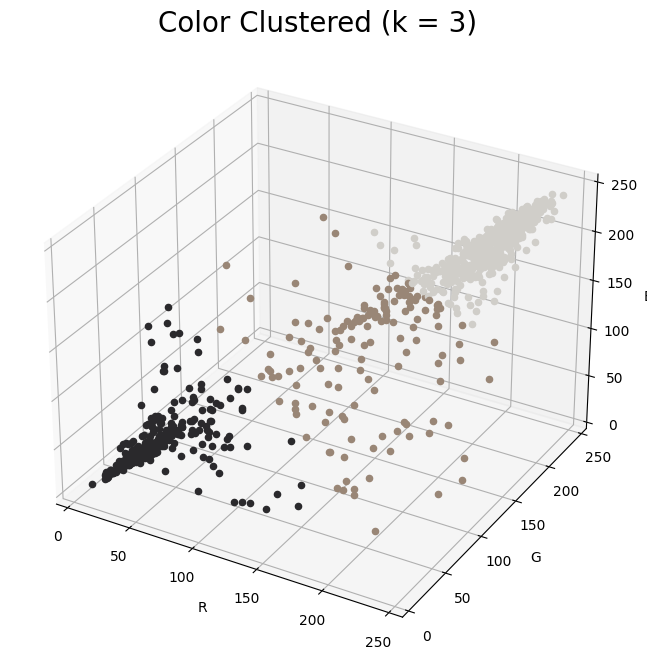

In [17]:
show_data_3d(df)

As shown in the image above, it seems to be well mapped with 3 colors.
> Now we will cluster with 25 colors. <br>  - ([mycolor.py](mycolor.py) has sort function for colors)

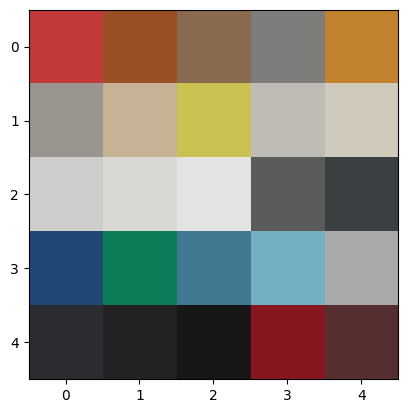

In [18]:
k = 25
kmeans = KMeans(n_clusters = k).fit(points)
centers = kmeans.cluster_centers_.round().astype(int)
show_colors_2d(centers)

Based on this, draw a 3d plot.

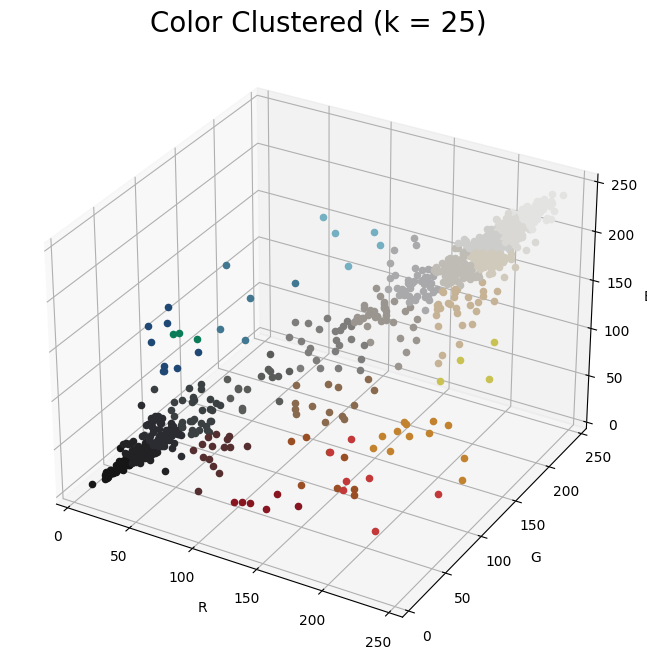

In [19]:
df['cluster'] = kmeans.labels_
colors = []
for row in df['cluster']:
  colors.append(centers[row])
df['color'] = colors
show_data_3d(df)

Although we got 25 colors from 1000 colors, <B>there are too many similar colors</B>.
> * To solve this problem, I found that multiple clustering will solve this.
> * With <b>k</b> and difference <b>d</b> as the number of initial clusters, a color palette is extracted with appropriate <b>k</b> and <b>d</b>. Here we use (500, 3)

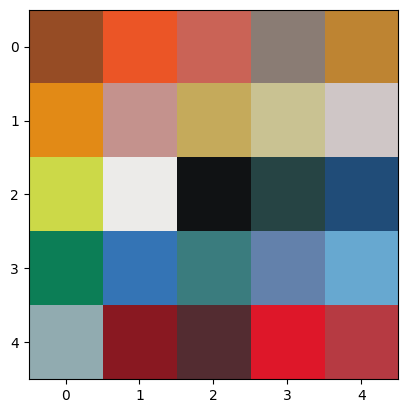

In [65]:
k, d = 500, 3 #initial cluster numbers, difference
kmeans = KMeans(n_clusters = k).fit(points)
centers = kmeans.cluster_centers_.round().astype(int)
df['cluster'] = kmeans.labels_
while k > 25 :  #target numbers : k = 5
  if k - d < 25 : k = 25
  else : k -= d
  kmeans = KMeans(n_clusters = k).fit(centers)
  centers = kmeans.cluster_centers_.round().astype(int)
  labels, colors = [], []
  for row in df['cluster']:
    labels.append(kmeans.labels_[row])
    colors.append(centers[kmeans.labels_[row]])
  df['cluster'], df['color'] = labels, colors

show_colors_2d(centers)

You can see that the color palette came out more evenly than before. <br>
Based on this, draw a 3d plot.


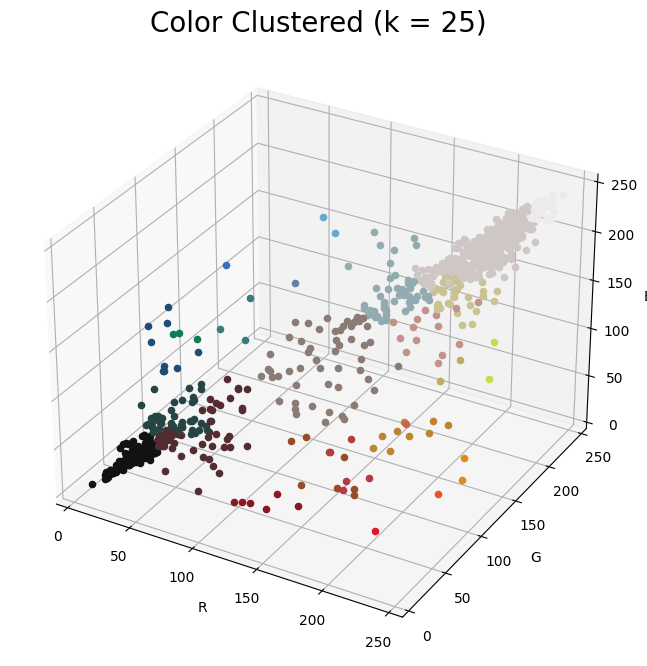

In [66]:
show_data_3d(df)

* We need to find the closest color to the colors we found.
* Mycolor has a closest_color function based on css color, but it doesn't give good results.
* So, I used ArtyClick ["Color Name Finder"](https://colors.artyclick.com/color-name-finder/) to get more universal colors.
* Before that, save the rgb values ​​we collected as a csv file.


In [68]:
with open("../data/original_RGB.csv", 'w', encoding='utf-8',newline='') as f:
  writer = csv.writer(f)
  writer.writerow(('#R','G','B'))
  for rgb in centers:
    writer.writerow(rgb)

 Find adjacent RGB and its names of 25 colors and save them as a csv file. [original_RGB.csv](../data/original_RGB.csv)


> The process of finding the closest color to the above colors is covered in [GetColorName.ipynb](../data_crawl/GetColorName.ipynb)

***Now update (df) with the main colors we got***

In [69]:
main_colors = []
with open("../data/main_colors.csv", 'r', encoding ='utf-8')  as f:
  for items in csv.reader(f):
    if items[0].startswith('#'): continue
    main_colors.append({'name' : items[0], 'RGB' : items[1]})

colors, names = [], []
for idx, row in df.iterrows():
  colors.append(np.array(eval(main_colors[row['cluster']]['RGB'])))
  names.append(main_colors[row['cluster']]['name'])
df['color'], df['name'] = colors, names
df
  


,R,G,B,cluster,color,name
0,218,222,224,2,"[197, 201, 199]",Silver
1,203,204,206,2,"[197, 201, 199]",Silver
2,52,51,50,13,"[72, 49, 49]",Woody Brown
3,199,204,206,2,"[197, 201, 199]",Silver
4,223,226,227,2,"[197, 201, 199]",Silver
...,...,...,...,...,...,...
995,217,217,218,2,"[197, 201, 199]",Silver
996,236,230,220,17,"[243, 233, 229]",Dawn Pink
997,216,217,221,2,"[197, 201, 199]",Silver
998,180,171,170,2,"[197, 201, 199]",Silver


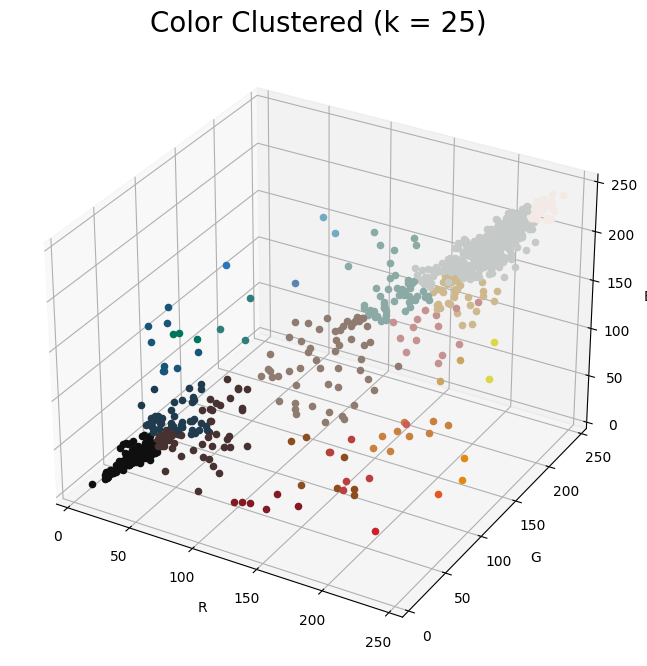

In [70]:
show_data_3d(df)


Although different from the previous 3d plot, **we got universal color names**.
>Now create shoes(updated).csv with the obtained colors.

In [71]:
with open('../data/shoes(updated).csv','w',encoding='utf-8', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(('#Name','Brand','color','Link','wish','review'))
  for idx, row in enumerate(shoes.data):
    row[2] = {'name' : df['name'][idx], 'RGB' : tuple(df['color'][idx])}
    writer.writerow(row)


Except for few shoes, it generally matches the color of the shoes.

<img src = "https://user-images.githubusercontent.com/67538999/206905726-0eb1a8bc-341b-41ec-a32d-5744f871eee5.png">

[Back to <b>contents</b>](../README.md)